In [2]:
!pip3 install pysam
!pip3 install polars==0.20

In [3]:
from pysam import FastaFile
dna = FastaFile("../genome/AT_reference/GCF_000001735.4_TAIR10.1_genomic.fna")
print(dna.references)
chr_to_references = {
    "1": "CHR1",
    "2": "CHR2",
    "3": "CHR3",
    "4": "CHR4",
    "5": "CHR5",
}
a = dna.fetch(chr_to_references["1"], 0, 1000)

print(dna.get_reference_length(chr_to_references["1"]))


encode_dict = {
    "[mask]": 0,
    "A": 1,
    "C": 2,
    "G": 3,
    "T": 4,
    "Y": 5, # C or T
    "R": 6, # A or G
    "W": 7, # A or T
    "S": 8, # C or G
    "M": 9, # A or C
    "K": 10, # G or T
    "B": 11, # C or G or T
    "D": 12, # A or G or T
    "H": 13, # A or C or T
    "V": 14, # A or C or G
    "a": 1,
    "c": 2,
    "g": 3,
    "t": 4,
    "N": -1,
}

encode_bases = lambda bases: [encode_dict[base] for base in bases]



['CHR1', 'CHR2', 'CHR3', 'CHR4', 'CHR5', 'NC_037304.1', 'NC_000932.1']
30427671


In [5]:
import networkx as nx
import polars as pl

methylome_base_dir = "/mnt/fast/epigenomics/MA3_new_total_original_methylome/"

G = nx.DiGraph()

with open(methylome_base_dir + "nodelist.txt") as f:
    nodes = f.read().splitlines()

with open(methylome_base_dir + "edgelist.txt") as f:
    edges = f.read().splitlines()

for node in nodes: 

    if node == "filename,node,gen,meth" or node == "":
        continue

    
    filename, node, gen, meth = node.split(',')
    line = node.split('_')[1]
    
    node = {
        'filename': filename,
        'node': node,
        'line': int(line),
        'gen': int(gen),
        'meth': True if meth == 'Y' else False
    }

    
    G.add_node(node['node'], **node)

for edge in edges:

    if edge == "from to":
        continue

    from_, to_ = edge.split(" ")

    G.add_edge(from_, to_)


for (idx, node) in G.nodes(data=True):
    if node["filename"] != "-":
        df = pl.read_csv(node["filename"], separator="\t", ignore_errors=True).filter(pl.col("seqnames").is_not_nan() & pl.col("seqnames").is_not_null()).rename({"seqnames": "chromosome"})
       # df = df.with_columns(pl.col("status").map_elements(lambda x: 0. if x == "U" else 0.5 if x == "I" else 1.).alias("status_numeric"))
        display(df)
    node["sites"] = df

def get_predecessor_node(node):
    if not node in G:
        return None

    pred = iter(G.pred[node])

    if pred.__length_hint__() == 0:
        return None

    pred = G.nodes[next(pred)]

    if pred["meth"]:
        return pred
    else:
        return get_predecessor_node(pred['node'])

def get_pred_node_by_gen_and_line(gen, line):
    pred =  get_predecessor_node(f"{gen}_{line}")
    if pred is None:
        return None, None
    gen, line = pred["node"].split('_')
    return int(gen), int(line)



chromosome,start,strand,context,counts.methylated,counts.total,posteriorMax,status,rc.meth.lvl,context.trinucleotide
i64,i64,str,str,i64,i64,f64,str,f64,str
1,1,"""+""","""CHH""",0,0,1.0,"""I""",0.0503,"""CCC"""
1,2,"""+""","""CHH""",0,0,0.9879,"""I""",0.0508,"""CCT"""
1,3,"""+""","""CHH""",0,0,0.977,"""I""",0.0512,"""CTA"""
1,8,"""+""","""CHH""",0,1,0.9672,"""I""",0.0516,"""CCC"""
1,9,"""+""","""CHH""",0,1,0.9579,"""I""",0.052,"""CCT"""
1,10,"""+""","""CHH""",0,1,0.9491,"""I""",0.0523,"""CTA"""
1,15,"""+""","""CHH""",0,2,0.9407,"""I""",0.0527,"""CCC"""
1,16,"""+""","""CHH""",0,2,0.932,"""I""",0.053,"""CCT"""
1,17,"""+""","""CHH""",0,2,0.9228,"""I""",0.0534,"""CTA"""


chromosome,start,strand,context,counts.methylated,counts.total,posteriorMax,status,rc.meth.lvl,context.trinucleotide
i64,i64,str,str,i64,i64,f64,str,f64,str
1,1,"""+""","""CHH""",0,0,0.9951,"""I""",0.0663,"""CCC"""
1,2,"""+""","""CHH""",0,0,0.9777,"""I""",0.0674,"""CCT"""
1,3,"""+""","""CHH""",0,0,0.9616,"""I""",0.0684,"""CTA"""
1,8,"""+""","""CHH""",0,0,0.9467,"""I""",0.0694,"""CCC"""
1,9,"""+""","""CHH""",0,0,0.9329,"""I""",0.0703,"""CCT"""
1,10,"""+""","""CHH""",0,0,0.9202,"""I""",0.0711,"""CTA"""
1,15,"""+""","""CHH""",0,2,0.9086,"""I""",0.0719,"""CCC"""
1,16,"""+""","""CHH""",0,2,0.8951,"""I""",0.0727,"""CCT"""
1,17,"""+""","""CHH""",1,2,0.8794,"""I""",0.0738,"""CTA"""


chromosome,start,strand,context,counts.methylated,counts.total,posteriorMax,status,rc.meth.lvl,context.trinucleotide
i64,i64,str,str,i64,i64,f64,str,f64,str
1,1,"""+""","""CHH""",0,0,0.6984,"""M""",0.1167,"""CCC"""
1,2,"""+""","""CHH""",0,0,0.6768,"""M""",0.1152,"""CCT"""
1,3,"""+""","""CHH""",0,0,0.6563,"""M""",0.1138,"""CTA"""
1,8,"""+""","""CHH""",0,0,0.6369,"""M""",0.1125,"""CCC"""
1,9,"""+""","""CHH""",0,0,0.6184,"""M""",0.1112,"""CCT"""
1,10,"""+""","""CHH""",0,0,0.6008,"""M""",0.1101,"""CTA"""
1,15,"""+""","""CHH""",0,0,0.5841,"""M""",0.1089,"""CCC"""
1,16,"""+""","""CHH""",0,0,0.5681,"""M""",0.1078,"""CCT"""
1,17,"""+""","""CHH""",0,0,0.5529,"""M""",0.1068,"""CTA"""


chromosome,start,strand,context,counts.methylated,counts.total,posteriorMax,status,rc.meth.lvl,context.trinucleotide
i64,i64,str,str,i64,i64,f64,str,f64,str
1,1,"""+""","""CHH""",0,0,0.9997,"""M""",0.1368,"""CCC"""
1,2,"""+""","""CHH""",0,0,0.9599,"""M""",0.1341,"""CCT"""
1,3,"""+""","""CHH""",0,0,0.9234,"""M""",0.1316,"""CTA"""
1,8,"""+""","""CHH""",0,0,0.8898,"""M""",0.1293,"""CCC"""
1,9,"""+""","""CHH""",0,0,0.8591,"""M""",0.1272,"""CCT"""
1,10,"""+""","""CHH""",0,0,0.8311,"""M""",0.1253,"""CTA"""
1,15,"""+""","""CHH""",0,1,0.8056,"""M""",0.1236,"""CCC"""
1,16,"""+""","""CHH""",0,1,0.7853,"""M""",0.1222,"""CCT"""
1,17,"""+""","""CHH""",1,1,0.7697,"""M""",0.1212,"""CTA"""


chromosome,start,strand,context,counts.methylated,counts.total,posteriorMax,status,rc.meth.lvl,context.trinucleotide
i64,i64,str,str,i64,i64,f64,str,f64,str
1,1,"""+""","""CHH""",0,0,0.9999,"""M""",0.1363,"""CCC"""
1,2,"""+""","""CHH""",0,0,0.9629,"""M""",0.1338,"""CCT"""
1,3,"""+""","""CHH""",0,0,0.9289,"""M""",0.1315,"""CTA"""
1,8,"""+""","""CHH""",0,0,0.8977,"""M""",0.1294,"""CCC"""
1,9,"""+""","""CHH""",0,0,0.8691,"""M""",0.1275,"""CCT"""
1,10,"""+""","""CHH""",0,0,0.843,"""M""",0.1258,"""CTA"""
1,15,"""+""","""CHH""",0,0,0.8193,"""M""",0.1242,"""CCC"""
1,16,"""+""","""CHH""",0,0,0.7977,"""M""",0.1227,"""CCT"""
1,17,"""+""","""CHH""",0,0,0.7783,"""M""",0.1214,"""CTA"""


chromosome,start,strand,context,counts.methylated,counts.total,posteriorMax,status,rc.meth.lvl,context.trinucleotide
i64,i64,str,str,i64,i64,f64,str,f64,str
1,1,"""+""","""CHH""",0,0,0.9825,"""I""",0.0626,"""CCC"""
1,2,"""+""","""CHH""",0,0,0.9574,"""I""",0.0639,"""CCT"""
1,3,"""+""","""CHH""",0,0,0.9354,"""I""",0.0651,"""CTA"""
1,8,"""+""","""CHH""",0,1,0.9164,"""I""",0.0661,"""CCC"""
1,9,"""+""","""CHH""",0,1,0.8986,"""I""",0.067,"""CCT"""
1,10,"""+""","""CHH""",0,1,0.8819,"""I""",0.0679,"""CTA"""
1,15,"""+""","""CHH""",0,1,0.8661,"""I""",0.0689,"""CCC"""
1,16,"""+""","""CHH""",0,1,0.851,"""I""",0.0697,"""CCT"""
1,17,"""+""","""CHH""",0,1,0.8365,"""I""",0.0706,"""CTA"""


chromosome,start,strand,context,counts.methylated,counts.total,posteriorMax,status,rc.meth.lvl,context.trinucleotide
i64,i64,str,str,i64,i64,f64,str,f64,str
1,1,"""+""","""CHH""",0,0,0.9999,"""I""",0.0648,"""CCC"""
1,2,"""+""","""CHH""",0,1,0.9833,"""I""",0.0658,"""CCT"""
1,3,"""+""","""CHH""",0,1,0.9671,"""I""",0.0669,"""CTA"""
1,8,"""+""","""CHH""",0,2,0.9512,"""I""",0.0679,"""CCC"""
1,9,"""+""","""CHH""",0,2,0.9339,"""I""",0.069,"""CCT"""
1,10,"""+""","""CHH""",1,2,0.9147,"""I""",0.0702,"""CTA"""
1,15,"""+""","""CHH""",0,2,0.9101,"""I""",0.0705,"""CCC"""
1,16,"""+""","""CHH""",0,2,0.9043,"""I""",0.0708,"""CCT"""
1,17,"""+""","""CHH""",0,2,0.8971,"""I""",0.0713,"""CTA"""


chromosome,start,strand,context,counts.methylated,counts.total,posteriorMax,status,rc.meth.lvl,context.trinucleotide
i64,i64,str,str,i64,i64,f64,str,f64,str
1,1,"""+""","""CHH""",0,0,0.9997,"""I""",0.0844,"""CCC"""
1,2,"""+""","""CHH""",0,0,0.9737,"""I""",0.0865,"""CCT"""
1,3,"""+""","""CHH""",0,0,0.9516,"""I""",0.0883,"""CTA"""
1,8,"""+""","""CHH""",0,0,0.9332,"""I""",0.0898,"""CCC"""
1,9,"""+""","""CHH""",0,0,0.9183,"""I""",0.091,"""CCT"""
1,10,"""+""","""CHH""",0,0,0.9068,"""I""",0.0919,"""CTA"""
1,15,"""+""","""CHH""",0,0,0.8985,"""I""",0.0926,"""CCC"""
1,16,"""+""","""CHH""",0,0,0.8933,"""I""",0.093,"""CCT"""
1,17,"""+""","""CHH""",0,0,0.8912,"""I""",0.0931,"""CTA"""


: 

In [12]:
import numpy as np

embedding_by_chr = {}

for chrsm in range(1, 6):
    print(chrsm)
    data = pl.DataFrame({ "sequence": encode_bases(dna.fetch(chr_to_references[f"{chrsm}"]))})

    # for g in ["gbM", "teM", "UM"]:
    #     df = pl.read_csv(f"/mnt/fast/epigenomics/genes/{g}_gene_anotation_extract_Arabidopsis.bed", separator="\t", ignore_errors=True, has_header=False, new_columns=["chromosome", "start", "end", "name", "type", "strand"])
    #     # turn coordinates like 13000-13600 into bitarray like 000001111111100000
    #     a = np.zeros(data.height, dtype=np.int8)


    #     for row in df.filter(pl.col("chromosome") == chrsm).iter_rows(named=True):
    #         a[row["start"]:row["end"]] = 1 if row["strand"] == "+" else -1

    #     s = pl.Series(f"{g}", a)

    #     data = data.with_columns(s)

    # for i in range(1,37):
    #     df = pl.read_csv(f"/mnt/fast/epigenomics/chr_states/At_segments_S{i}.bed", separator="\t", ignore_errors=True, has_header=False, new_columns=["chromosome", "start", "end", "state"])
    #     # turn coordinates like 13000-13600 into bitarray like 000001111111100000
    #     a = np.zeros(data.height, dtype=np.int8)
       

    #     for row in df.filter(pl.col("chromosome") == chrsm).iter_rows(named=True):
    #         a[row["start"]:row["end"]] = 1

    #     s = pl.Series(f"{i}", a)
      

    #     data = data.with_columns(s)

    # for mod in ["h2az","H3","H3K27Me3","H3K36Me3","H3K4Me1","H3K4Me3","H3K56Ac","input"]:
    #     print(mod)
    #     df = pl.read_csv(f"/mnt/fast/epigenomics/modifications/final/{mod}.bed", separator="\t", ignore_errors=True, has_header=False, new_columns=["chromosome", "start", "end"])

    #     # turn coordinates like 13000-13600 into bitarray like 000001111111100000
    #     a = np.zeros(data.height, dtype=np.int8)

    #     for row in df.filter(pl.col("chromosome") == chrsm).iter_rows(named=True):
    #         a[row["start"]:row["end"]] = 1

    #     s = pl.Series(f"{mod}", a)

    #     data = data.with_columns(s)
       
    embedding_by_chr[chrsm] = data

# display(embedding_by_chr[1])
# display(embedding_by_chr[2])
# display(embedding_by_chr[3])
# display(embedding_by_chr[4])
# display(embedding_by_chr[5])

1
2
3
4
5


In [13]:
for (chrsm, embedding) in embedding_by_chr.items():
    embedding.write_parquet(f"./embeddings/chr_{chrsm}.parquet")

In [14]:
for (chrsm, embedding) in embedding_by_chr.items():
    n = embedding.to_numpy()
    n.tofile(f"./embeddings/chr_{chrsm}.bin")

In [15]:
def steady_state(alpha: float, beta: float):
    pi1 = lambda a, b:  (a * ((1.0 - a) ** 2  - (1.0 - b)**(2) - 1.0)) / ((a + b) * ((a + b - 1.0)**(2) - 2.0))
    pi2 = lambda a, b:  (4.0 * a * b * (a + b - 2.0)) / ((a + b) * ((a + b - 1.0)**(2) - 2.0));
    
    return pi1(alpha, beta) + 0.5 * pi2(alpha, beta)



In [39]:
df = G.nodes["0_0"]["sites"]

    print(chrsm, df.height)
    for s in df.iter_slices(n_rows=1000):
        print(s)
        break



1 255744
shape: (1_000, 10)
┌────────────┬────────┬────────┬─────────┬───┬──────────────┬────────┬─────────────┬───────────────┐
│ chromosome ┆ start  ┆ strand ┆ context ┆ … ┆ posteriorMax ┆ status ┆ rc.meth.lvl ┆ status_numeri │
│ ---        ┆ ---    ┆ ---    ┆ ---     ┆   ┆ ---          ┆ ---    ┆ ---         ┆ c             │
│ i64        ┆ i64    ┆ str    ┆ str     ┆   ┆ f64          ┆ str    ┆ f64         ┆ ---           │
│            ┆        ┆        ┆         ┆   ┆              ┆        ┆             ┆ f64           │
╞════════════╪════════╪════════╪═════════╪═══╪══════════════╪════════╪═════════════╪═══════════════╡
│ 1          ┆ 23151  ┆ +      ┆ CG      ┆ … ┆ 0.9999       ┆ U      ┆ 0.0025      ┆ 0.0           │
│ 1          ┆ 23152  ┆ -      ┆ CG      ┆ … ┆ 0.9999       ┆ U      ┆ 0.0025      ┆ 0.0           │
│ 1          ┆ 23180  ┆ +      ┆ CG      ┆ … ┆ 0.9998       ┆ U      ┆ 0.0025      ┆ 0.0           │
│ 1          ┆ 23181  ┆ -      ┆ CG      ┆ … ┆ 0.9999       ┆ U

In [67]:
df = pl.read_csv("/mnt/fast/epigenomics/MA_Zilberman/GSM6198489_W16_B_TAIR10.chr.all.single-c.CG.bed", separator="\t", ignore_errors=True).rename({"seqnames": "chromosome"})
display(df)
mean_meth_lvl = df.get_column("rc.meth.lvl").mean()
print(mean_meth_lvl)

chromosome,start,strand,context,counts.methylated,counts.total,posteriorMax,status,rc.meth.lvl
str,i64,str,str,i64,i64,f64,str,f64
"""chr1""",109,"""+""","""CG""",10,14,1.0,"""M""",0.80875
"""chr1""",110,"""-""","""CG""",19,19,1.0,"""M""",0.80875
"""chr1""",115,"""+""","""CG""",6,7,1.0,"""M""",0.80875
"""chr1""",116,"""-""","""CG""",13,17,1.0,"""M""",0.80875
"""chr1""",161,"""+""","""CG""",7,12,1.0,"""M""",0.80875
"""chr1""",162,"""-""","""CG""",18,20,1.0,"""M""",0.80875
"""chr1""",310,"""+""","""CG""",4,10,1.0,"""M""",0.80875
"""chr1""",311,"""-""","""CG""",12,26,1.0,"""M""",0.80875
"""chr1""",500,"""+""","""CG""",10,16,1.0,"""M""",0.80875


0.09548518654370153


In [56]:
import os
import subprocess
import shutil




def alphabeta(pedigree: nx.DiGraph, sites = 1024): 
    """
    Run alphabeta-rs to calculate inheritance rates for all slices of a specified size in the genome.
    """

    edgelist = "from,to\n"
    edgelist+= "\n".join([f"{edge[0]},{edge[1]}" for edge in pedigree.edges])

    slices = []

    for (_, node) in pedigree.nodes(data=True):
        if node["meth"]:
            df : pl.DataFrame = node["sites"]
            dfs = df.filter(pl.col("context") == "CG").partition_by("chromosome", as_dict=True)
            for (chrsm, df) in dfs.items():
                    for (i, s) in enumerate(df.iter_slices(n_rows=sites)):
                        dir = f"./slices/{sites}/chr:{chrsm}_{i}"
                        dir = os.path.abspath(dir)
                        
                       

                        start = s.get_column("start").min()
                        end = s.get_column("start").max()

                        if node["node"] == "0_0": # Setup when running for the first time
                            if os.path.exists(dir):
                                shutil.rmtree(dir)
                            os.makedirs(dir)

                            nodelist = "filename,node,gen,meth\n"
                            nodelist += "\n".join([(f"{dir}/{node['node']}.bed" if node['meth'] else "-") + f",{node['node']},{node['gen']},{'Y' if node['meth'] else 'N'}" for (_,node) in pedigree.nodes(data=True)])
                            
                            open(f"{dir}/nodelist.txt", "w").write(nodelist)
                            open(f"{dir}/edgelist.txt", "w").write(edgelist)

                            # if end-start > 1000:
                            #     print(f"Sites between {chrsm}:{start}-{end} are far-away from each other ({end-start} bp)." )

                            slices.append((chrsm, i, start, end))

                        s.write_csv(f"{dir}/{node['node']}.bed", separator="\t")
                        
                        
                        
                        
                        

    slices = pl.DataFrame(slices, schema=["chrsm", "slice", "start", "end"])
    # display(slices)
    results = []
    
    for (i, slc) in enumerate(os.listdir(f"./slices/{sites}")):
        dir = os.path.abspath(f"./slices/{sites}/{slc}")
   
        # print(f"Running alphabeta-rs for {dir}")
        res = subprocess.run(["alphabeta", "-n" ,f"{dir}/nodelist.txt", "-e", f"{dir}/edgelist.txt", "-o", f"{dir}", "-i", "10" ], capture_output=True)
        # print(res.stdout.decode("utf-8"))
        # print(res.stderr.decode("utf-8"))

        model = pl.read_csv(f"{dir}/analysis.txt", separator="\t", has_header=False, new_columns=["key", "value"], n_rows=16, infer_schema_length=16, ignore_errors=True)
        alpha = model.filter(pl.col("key") == "Alpha").get_column("value").max()
        beta = model.filter(pl.col("key") == "Beta").get_column("value").max()
        std_st = steady_state(alpha, beta)

        # shutil.rmtree(dir)
        results.append((alpha, beta, std_st))

    results = pl.DataFrame(results, schema=["alpha", "beta", "std_st"])
    
    results = slices.hstack(results)
    display(results)
    results.write_parquet(f"./alphabeta_{sites}.parquet")
    return results




In [ ]:

alphabeta(G, 100000)
alphabeta(G, 10000)


In [57]:
alphabeta(G, 2**15)
alphabeta(G, 2**12)
alphabeta(G, 2**9)

Sites between 1:23151-2824243 are far-away from each other (2801092 bp).
Sites between 1:2824285-5994539 are far-away from each other (3170254 bp).
Sites between 1:5994540-9713252 are far-away from each other (3718712 bp).
Sites between 1:9713309-16782044 are far-away from each other (7068735 bp).
Sites between 1:16782133-20303337 are far-away from each other (3521204 bp).
Sites between 1:20303383-23658027 are far-away from each other (3354644 bp).
Sites between 1:23658054-27488169 are far-away from each other (3830115 bp).
Sites between 1:27488170-30403701 are far-away from each other (2915531 bp).
Sites between 2:73228-7612672 are far-away from each other (7539444 bp).
Sites between 2:7612753-11028699 are far-away from each other (3415946 bp).
Sites between 2:11028700-14775849 are far-away from each other (3747149 bp).
Sites between 2:14775872-18948915 are far-away from each other (4173043 bp).
Sites between 2:18948921-19696803 are far-away from each other (747882 bp).
Sites between 

chrsm,slice,start,end,alpha,beta,std_st
i64,i64,i64,i64,f64,f64,f64
1,0,23151,2824243,0.000581,0.001588,0.267738
1,1,2824285,5994539,0.000764,0.001891,0.287758
1,2,5994540,9713252,0.000648,0.002142,0.232153
1,3,9713309,16782044,0.000705,0.001886,0.271913
1,4,16782133,20303337,0.000559,0.001644,0.253931
1,5,20303383,23658027,0.000623,0.001576,0.283406
1,6,23658054,27488169,0.000682,0.001959,0.258113
1,7,27488170,30403701,0.000573,0.001872,0.234344
2,0,73228,7612672,0.00069,0.00192,0.264516


Sites between 1:23151-385428 are far-away from each other (362277 bp).
Sites between 1:385555-827554 are far-away from each other (441999 bp).
Sites between 1:827575-1113773 are far-away from each other (286198 bp).
Sites between 1:1113800-1490903 are far-away from each other (377103 bp).
Sites between 1:1505046-1914305 are far-away from each other (409259 bp).
Sites between 1:1914322-2291439 are far-away from each other (377117 bp).
Sites between 1:2291440-2546868 are far-away from each other (255428 bp).
Sites between 1:2546869-2824243 are far-away from each other (277374 bp).
Sites between 1:2824285-3163182 are far-away from each other (338897 bp).
Sites between 1:3163229-3590434 are far-away from each other (427205 bp).
Sites between 1:3590438-3924312 are far-away from each other (333874 bp).
Sites between 1:3924463-4352729 are far-away from each other (428266 bp).
Sites between 1:4352730-4744451 are far-away from each other (391721 bp).
Sites between 1:4744452-5243788 are far-away

chrsm,slice,start,end,alpha,beta,std_st
i64,i64,i64,i64,f64,f64,f64
1,0,23151,385428,0.000594,0.002053,0.224516
1,1,385555,827554,0.000763,0.001794,0.298514
1,2,827575,1113773,0.000632,0.001618,0.280911
1,3,1113800,1490903,0.000639,0.001882,0.253513
1,4,1505046,1914305,0.00089,0.002459,0.265768
1,5,1914322,2291439,0.000644,0.001475,0.303797
1,6,2291440,2546868,0.000782,0.001896,0.291876
1,7,2546869,2824243,0.000496,0.001257,0.282754
1,8,2824285,3163182,0.000797,0.001531,0.342265


Sites between 1:23151-93383 are far-away from each other (70232 bp).
Sites between 1:93407-129398 are far-away from each other (35991 bp).
Sites between 1:129514-237606 are far-away from each other (108092 bp).
Sites between 1:237611-278693 are far-away from each other (41082 bp).
Sites between 1:278694-314229 are far-away from each other (35535 bp).
Sites between 1:314230-335389 are far-away from each other (21159 bp).
Sites between 1:335390-359606 are far-away from each other (24216 bp).
Sites between 1:359644-385428 are far-away from each other (25784 bp).
Sites between 1:385555-493905 are far-away from each other (108350 bp).
Sites between 1:493973-527757 are far-away from each other (33784 bp).
Sites between 1:527758-629291 are far-away from each other (101533 bp).
Sites between 1:629292-658095 are far-away from each other (28803 bp).
Sites between 1:658102-713672 are far-away from each other (55570 bp).
Sites between 1:713674-726826 are far-away from each other (13152 bp).
Sites 

chrsm,slice,start,end,alpha,beta,std_st
i64,i64,i64,i64,f64,f64,f64
1,0,23151,93383,0.001071,0.002133,0.334248
1,1,93407,129398,0.000368,0.000947,0.279668
1,2,129514,237606,0.001242,0.003465,0.263781
1,3,237611,278693,0.000324,0.001701,0.159873
1,4,278694,314229,0.000184,0.000659,0.218603
1,5,314230,335389,0.001337,0.004983,0.211554
1,6,335390,359606,0.000905,0.002303,0.282113
1,7,359644,385428,0.000676,0.002131,0.240797
1,8,385555,493905,0.001137,0.002278,0.332935


chrsm,slice,start,end,alpha,beta,std_st
i64,i64,i64,i64,f64,f64,f64
1,0,23151,93383,0.001071,0.002133,0.334248
1,1,93407,129398,0.000368,0.000947,0.279668
1,2,129514,237606,0.001242,0.003465,0.263781
1,3,237611,278693,0.000324,0.001701,0.159873
1,4,278694,314229,0.000184,0.000659,0.218603
1,5,314230,335389,0.001337,0.004983,0.211554
1,6,335390,359606,0.000905,0.002303,0.282113
1,7,359644,385428,0.000676,0.002131,0.240797
1,8,385555,493905,0.001137,0.002278,0.332935


In [ ]:
rows = []

for i in range(embedding_by_chr[1].height):
    alpha, beta, std_st, start, end =  alphabeta(G, 1, i)
    # print(i, alpha, beta, std_st, start, end)
    rows.append((1,i, start, end, alpha, beta, std_st))

    if i % 1000 == 0:
        print(i)
        targets = pl.DataFrame(rows,schema = ["chromosome", "location", "start", "end", "alpha", "beta", "steady_state"], orient="row")
        # display(targets)
        targets.write_parquet("./embeddings/targets.parquet")

targets = pl.DataFrame(rows,schema = ["chromosome", "location", "start", "end", "alpha", "beta", "steady_state"], orient="row")
targets.write_parquet("./embeddings/targets.parquet")
display(targets)




chromosome,location,start,end,alpha,beta,steady_state
i64,i64,null,null,null,null,null
1,0,null,null,null,null,null
1,1,null,null,null,null,null


chromosome,location,start,end,alpha,beta,steady_state
i64,i64,null,null,null,null,null
1,0,null,null,null,null,null
1,1,null,null,null,null,null
1,2,null,null,null,null,null
1,3,null,null,null,null,null
1,4,null,null,null,null,null
1,5,null,null,null,null,null
1,6,null,null,null,null,null
1,7,null,null,null,null,null
1,8,null,null,null,null,null


chromosome,location,start,end,alpha,beta,steady_state
i64,i64,null,null,null,null,null
1,0,null,null,null,null,null
1,1,null,null,null,null,null
1,2,null,null,null,null,null
1,3,null,null,null,null,null
1,4,null,null,null,null,null
1,5,null,null,null,null,null
1,6,null,null,null,null,null
1,7,null,null,null,null,null
1,8,null,null,null,null,null


chromosome,location,start,end,alpha,beta,steady_state
i64,i64,null,null,null,null,null
1,0,null,null,null,null,null
1,1,null,null,null,null,null
1,2,null,null,null,null,null
1,3,null,null,null,null,null
1,4,null,null,null,null,null
1,5,null,null,null,null,null
1,6,null,null,null,null,null
1,7,null,null,null,null,null
1,8,null,null,null,null,null


KeyboardInterrupt: 

In [ ]:
# There must be a subtle bug here because the rates are around 13x too high
def dT(i, j):
    gen_i, line_i = i.split('_')
    gen_j, line_j = j.split('_')

    if line_i != line_j: # Latest common ancestor is the root node
        return int(gen_i) + int(gen_j)
    else:
        return int(gen_j) - int(gen_i)

res_gain = pl.DataFrame()
res_loss = pl.DataFrame()
divergence = pl.DataFrame()
locations = G.nodes["0_0"]["sites"].get_column("start")
display(locations)
dTs = {}
pairs = [(i, j, dT(i,j), node_i["gen"], node_j["gen"], node_i["sites"].get_column("status_numeric"), node_j["sites"].get_column("status_numeric")) for (i, node_i) in G.nodes(data=True) for (j, node_j) in G.nodes(data=True) if (node_j["gen"] > node_i["gen"] or (node_j["gen"] == node_i["gen"]  and node_j["line"] > node_i["line"]))  and node_i["meth"] and node_j["meth"]]
for p in pairs:
        i,j , dT, gen_i, gen_j, states_i, states_j = p
        
        div = (states_j - states_i)
        
        
        gain = div.clip(lower_bound=0)
        loss = div.clip(upper_bound=0).abs()
        joined = pl.DataFrame({"i": states_i, "j": states_j, "diff": div.abs(), "gain": gain, "loss": loss})
        # print(i, j, dT)
        # display(joined[11200:])

        res_gain = res_gain.with_columns(gain.alias(f"{i}:{j}"))
        res_loss = res_loss.with_columns(loss.alias(f"{i}:{j}"))
        divergence = divergence.with_columns(div.abs().alias(f"{i}:{j}"))
        dTs[f"{i}:{j}"] = dT
        # print(i, j, dT, gen_i, gen_j)

# build Dataframe from dTs
dTs = pl.DataFrame([pl.Series("pairs" ,dTs.keys()), pl.Series("dT", dTs.values())] )
alpha_for_all_sites  = res_gain.mean_horizontal()
beta_for_all_sites = res_loss.mean_horizontal()
divergence_rolling = divergence.mean_horizontal().rolling_mean(1000)
divergence = divergence.mean()
divergence_over_time = dTs.hstack(divergence.transpose()).sort("dT")
display(divergence_over_time)
print(alpha_for_all_sites.mean() , beta_for_all_sites.mean())


start
i64
23151
23152
23180
23181
23188
23189
23296
23297
23337


pairs,dT,column_0
str,i64,f64
"""0_0:1_2""",1,0.02706
"""0_0:1_8""",1,0.03028
"""1_2:2_2""",1,0.026898
"""1_8:2_8""",1,0.021645
"""4_2:5_2""",1,0.02662
"""4_8:5_8""",1,0.022702
"""0_0:2_2""",2,0.023537
"""0_0:2_8""",2,0.031037
"""1_2:1_8""",2,0.027545


0.01649841949321116 0.017083439609481277


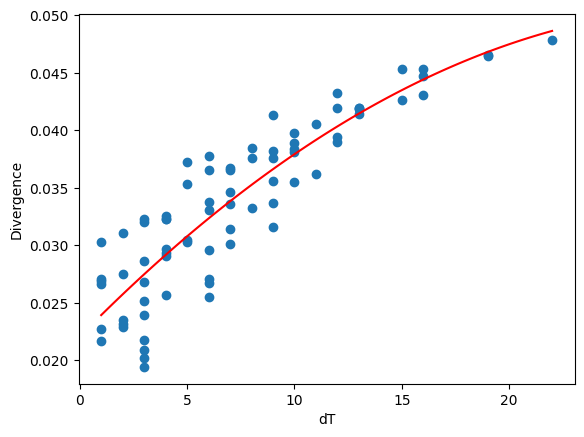

In [ ]:
# scatter plot of divergence over time
import matplotlib.pyplot as plt

plt.plot(divergence_over_time["dT"].to_numpy(), divergence_over_time["column_0"].to_numpy(), 'o')

plt.xlabel("dT")
plt.ylabel("Divergence")

#include line of best fit
import numpy as np

X = divergence_over_time["dT"].to_numpy()
y = divergence_over_time["column_0"].to_numpy()

p = np.polyfit(X, y, 2)
x = np.linspace(min(X), max(X), num=78)


plt.plot(x, np.poly1d(p)(x), color='red')

plt.show()


[       nan        nan        nan ... 0.02087179 0.02087179 0.02087179]


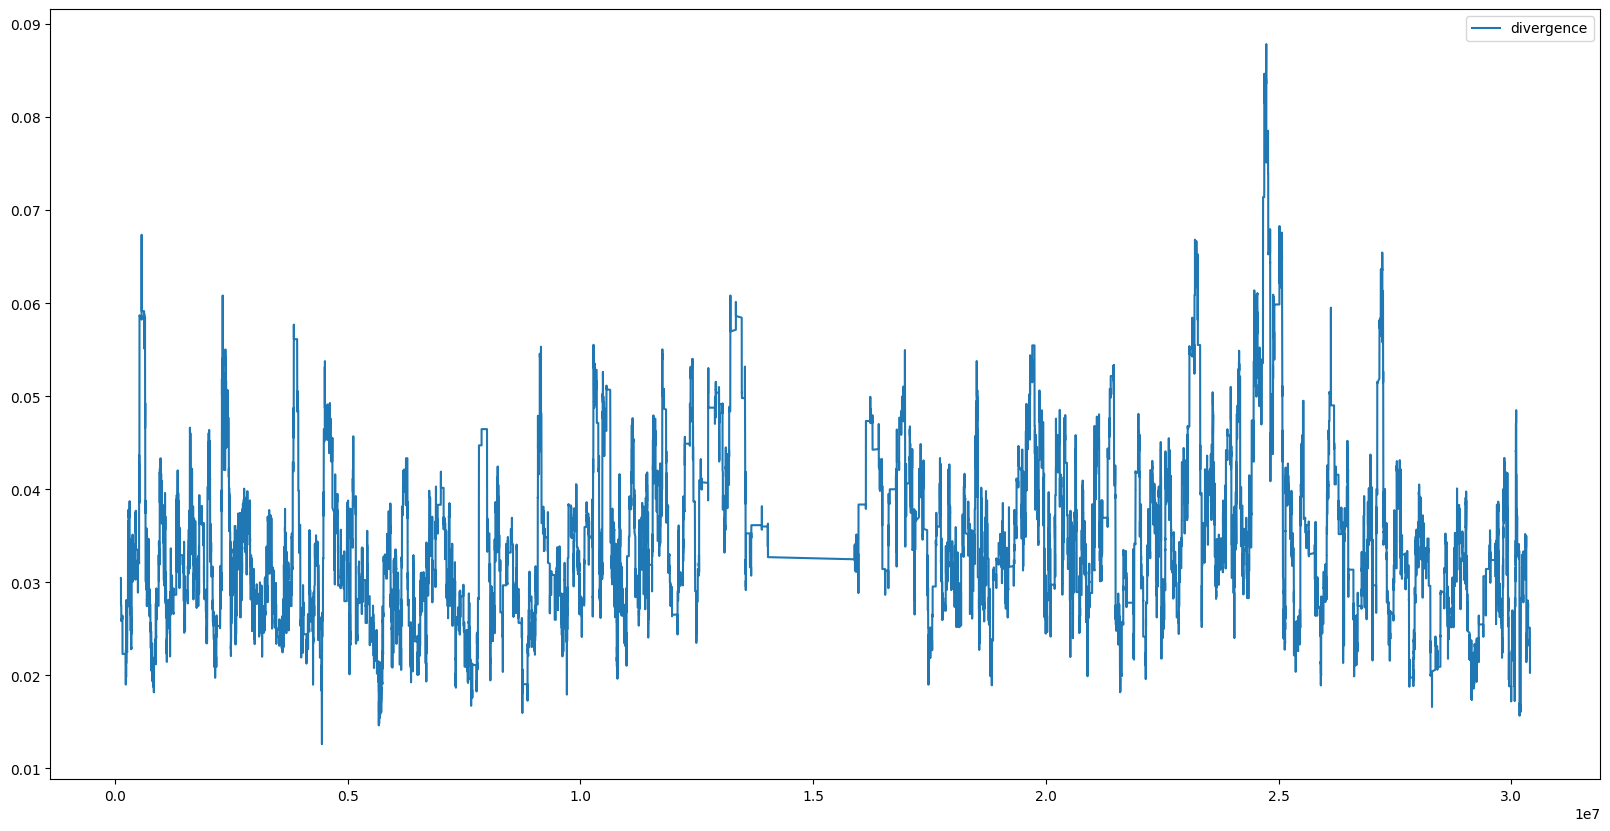

In [ ]:
# take rolling average, reduce to 1/10000th of the size, then plot
sites_div = pl.DataFrame({"location": locations, "divergence": divergence_rolling})
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 10))
print(divergence_rolling.to_numpy())
plt.plot(locations.to_numpy(), divergence_rolling.to_numpy(), label="divergence")

plt.legend()



In [ ]:
from pysam import FastxFile

with FastxFile('../genome/AT_reference/GCF_000001735.4_TAIR10.1_genomic.fna') as dna:
    for entry in dna:
        print(entry.name, entry.comment, entry.sequence[:10], sep='\n')


NC_003070.9
Arabidopsis thaliana chromosome 1 sequence
ccctaaaccc
NC_003071.7
Arabidopsis thaliana chromosome 2, partial sequence
NNNNNNNNNN
NC_003074.8
Arabidopsis thaliana chromosome 3, partial sequence
NNNNNNNNNN
NC_003075.7
Arabidopsis thaliana chromosome 4, partial sequence
NNNNNNNNNN
NC_003076.8
Arabidopsis thaliana chromosome 5, partial sequence
TATACCATGT
NC_037304.1
Arabidopsis thaliana ecotype Col-0 mitochondrion, complete genome
AGAGGTCAGA
NC_000932.1
Arabidopsis thaliana chloroplast, complete genome
ATGGGCGAAC
